# Neural Network

As we saw the typical supervised learning model was unable to predict fraud providers effectively I am going to try Neural network in this notebook.

We believe that deep learning is an important area of research that will play a critical role in the future of modeling class-imbalanced big data. Over the last 10 years, deep learning methods have grown in popularity as they have improved the state-of-the-art in speech recognition, computer vision, and other domains 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, \
recall_score, precision_score, accuracy_score, plot_confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

import os
import tempfile

Loading our ckeaned and final data for modeling process

In [5]:
df=pd.read_csv("./datasets/final_data.csv",index_col=0)

For modeling, as we know we can not add categorical column so I am selecting numerical columns

In [14]:
X=df[['total_drug_cost', 'total_claim_count', 'total_day_supply',
       'Opioid Claim Count', 'Opioid Prescribing Rate',
       'Long-Acting Opioid Claim Count', 'Long-Acting Opioid Prescribing Rate',
       'Total_Payment_Sum', 'Number of Suppliers',
       'Number of Supplier Beneficiaries', 'Number of Supplier Claims',
       'Average Supplier Submitted Charge',
       'Average Supplier Medicare Allow Amount',
       'Average Supplier Medicare Payment Amount',
       'Average Supplier Medicare Standard Amount', 'is_fraud']]

Spilliting the dataset as train, test and validation

In [15]:
# Use a utility from sklearn to split and shuffle our dataset.
X_train, X_test = train_test_split(X, test_size=0.25)

# split the validation data from train data
X_train, X_val = train_test_split(X_train, test_size=0.25)

As we know, we do not need our target variable is "is_fraud". Let's extract target variable from X_train, X_test and X_val

In [16]:
# Form np arrays of labels and features.

train_labels = np.array(X_train.pop('is_fraud'))
bool_train_labels = train_labels != 0
val_labels = np.array(X_val.pop('is_fraud'))
test_labels = np.array(X_test.pop('is_fraud'))


Making our datasets as an array

In [18]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)


Normalize the input features using the sklearn StandardScaler. This will set the mean to 0 and standard deviation to 1.

In [26]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)

X_val = ss.transform(X_val)
X_test = ss.transform(X_test)


In [28]:
# checking shape of X_train, X_test, X_val


X_train.shape,X_test.shape,X_val.shape

((100174, 15), (44523, 15), (33392, 15))

In [29]:
# checking the shape of 

train_labels.shape,val_labels.shape,test_labels.shape

((100174,), (33392,), (44523,))

In [30]:
# checking 0 and 1 in my target variable

neg, pos = np.bincount(df['is_fraud'])

In [31]:
neg, pos

(177973, 116)

Now I am setting all my matrices that I will require to evaluate my model in one list 

In [96]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

I am making one function in which will perform my modeling with two hiden layer and early stopping as my 
regularization.

In [102]:
def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
         #Intantiate the model
            
    model = keras.Sequential([
             keras.layers.Dense(
               64, activation='relu',
               input_shape=(X_train.shape[-1],)),
            keras.layers.Dropout(0.5),

        keras.layers.Dense(
          32, activation='relu'),      #adding hidden layer
          
      keras.layers.Dropout(0.5),
        
         keras.layers.Dense(           #adding hidden layer
          16, activation='relu'),
          
      keras.layers.Dropout(0.5),
        
      keras.layers.Dense(1, activation='sigmoid',             #output layer
                         bias_initializer=output_bias),
  ])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

I am setting 500 epochs and 8192 batch size so that it can detect more frauds

In [103]:
EPOCHS = 500
BATCH_SIZE = 8192

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [104]:
model=make_model()


In [105]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 64)                1024      
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_26 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                

In [108]:
# positive and negative features

pos_features = X_train[bool_train_labels]
neg_features = X_train[~bool_train_labels]

# Positive and negative labes(target variable)

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]


As we know our data is highly imbalance so I am going to resample my minority class.I am randomly increasing my minority class using np.random.

In [84]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

# resamples positive features and positive labels

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(100113, 15)

Concating the resampled poditive and negative features as well as the resampled positive and negative lables

In [111]:
# concatig the resampled positive and negative features and labels

X_res = np.concatenate([res_pos_features, neg_features], axis=0)
label_res = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(label_res))
np.random.shuffle(order)
X_res = X_res[order]
label_res = label_res[order]


If you're using tf.data the easiest way to produce balanced examples is to start with a positive and a negative dataset, and merge them

In [112]:
BUFFER_SIZE = 150000
def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [115]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

Steps per epoch the number of batches required to see each negative example once

In [117]:
resampled_steps_per_epoch = np.ceil(2.0*(neg)/BATCH_SIZE)
resampled_steps_per_epoch

44.0

In [118]:
resampled_model = make_model()


# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((X_val, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)

Epoch 1/500
44/44 [==============================] - 4s 100ms/step - loss: 0.7166 - tp: 98379.0000 - fp: 90783.0000 - tn: 89234.0000 - fn: 82052.0000 - accuracy: 0.5205 - precision: 0.5201 - recall: 0.5452 - auc: 0.5339 - val_loss: 0.7108 - val_tp: 14.0000 - val_fp: 28700.0000 - val_tn: 4675.0000 - val_fn: 3.0000 - val_accuracy: 0.1404 - val_precision: 4.8757e-04 - val_recall: 0.8235 - val_auc: 0.5444
Epoch 2/500
44/44 [==============================] - 3s 76ms/step - loss: 0.6737 - tp: 107430.0000 - fp: 86152.0000 - tn: 94052.0000 - fn: 72814.0000 - accuracy: 0.5590 - precision: 0.5550 - recall: 0.5960 - auc: 0.5983 - val_loss: 0.6791 - val_tp: 6.0000 - val_fp: 9932.0000 - val_tn: 23443.0000 - val_fn: 11.0000 - val_accuracy: 0.7022 - val_precision: 6.0374e-04 - val_recall: 0.3529 - val_auc: 0.5146
Epoch 3/500
44/44 [==============================] - 3s 78ms/step - loss: 0.6446 - tp: 94318.0000 - fp: 54861.0000 - tn: 125267.0000 - fn: 86002.0000 - accuracy: 0.6092 - precision: 0.6322 -

Getting the predictions

In [92]:
train_pred = resampled_model.predict(X_train, batch_size=BATCH_SIZE)
test_pred = resampled_model.predict(X_test, batch_size=BATCH_SIZE)

Let's see the scores

In [93]:
resampled_results = resampled_model.evaluate(X_test, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

loss :  0.49872449040412903
tp :  13.0
fp :  9396.0
tn :  35089.0
fn :  25.0
accuracy :  0.7884014844894409
precision :  0.0013816558057442307
recall :  0.34210526943206787
auc :  0.6408461332321167



In [120]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate medicare provider Detected (True Negatives): ', cm[0][0])
    print('Legitimate medicare provider Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent medicare provider Missed (False Negatives): ', cm[1][0])
    print('Fraudulent medicare provider Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent provider: ', np.sum(cm[1]))

Legitimate medicare provider Detected (True Negatives):  35089
Legitimate medicare provider Incorrectly Detected (False Positives):  9396
Fraudulent medicare provider Missed (False Negatives):  25
Fraudulent medicare provider Detected (True Positives):  13
Total Fraudulent provider:  38


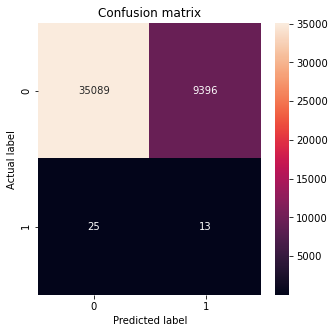

In [121]:
plot_cm(test_labels, test_pred)

Here you can see that, there are only 25 false negative which is good compared to other models 
we performed before. 

Our model detect 13 correct frauds and 35089 non fraud provider. It predicted 9396 fraud providers who are not fraud. Our recall score is 0.34 so it is saying that my model is 34% correctly identify the frauds.


As we know our class is highly imbalance so it is difficult to detect frauds from very low amout of previously detected 
fraud providers and in my excluded providers data there are more than 50000 missing NPI who are actual 
fraud providers. So In future I will gather mpore data and looking for that NPI in NPI registery website and will try to predict
the actual frauds.



credit : https://www.tensorflow.org/tutorials/structured_data/imbalanced_data